In [2]:
import os
import numpy as np 
import pandas as pd 
from skimage.io import imread
import matplotlib.pyplot as plt

C:\Users\Admin\AppData\Local\Temp\ipykernel_12864\360776289.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Reading csv file.

In [4]:
image_dir = 'data/train_v2'
df = pd.read_csv('data/train_ship_segmentations_v2.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In this dataset, we have rows with identical file names but different masks. Each row represents a mask for one ship in the image.

In [6]:
df[df.duplicated(subset=['ImageId'], keep=False)].head()

,ImageId,EncodedPixels
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...


Let's determine which images have ships and count the number of ships in each image.

In [7]:
df['ship'] = df['EncodedPixels'].map(lambda pixels: 1 if isinstance(pixels, str) else 0)
unique_images = df.groupby('ImageId').agg({'ship': 'sum'}).reset_index()

Take a look at the images and their masks. Here is rle_decode function to decode encoded pixels for images.

In [12]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

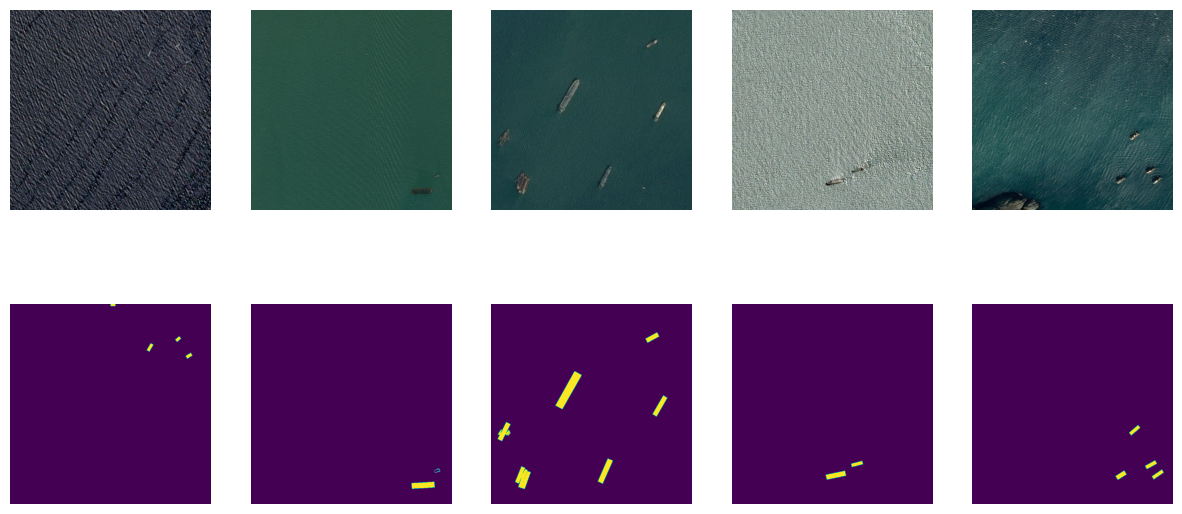

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))
for i, (index, row) in enumerate(unique_images[unique_images.ship > 1].sample(5).iterrows()):
    image = imread(os.path.join(image_dir, row['ImageId']))
    enc_masks = df[df.ImageId == row['ImageId']].EncodedPixels.values
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    for value in enc_masks:
        mask += rle_decode(value)

    axes[0, i].imshow(image)
    axes[1, i].imshow(mask)
    axes[0, i].axis('off')
    axes[1, i].axis('off')

Plot the distribution of the number of ships in the images.

<Axes: >

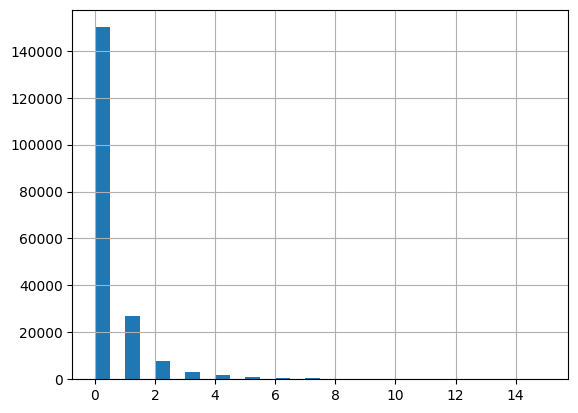

In [33]:
unique_images.ship.hist(bins=30)

We can see that there are significantly more empty images. Additionally, it's noticeable that ships constitute only a small part of the images. To ensure effective model training, it would be beneficial to balance the dataset.